# **Prescribing Drugs Using Past Reviews**

# Importing The Libraries

In [1]:
import numpy as np
import pandas as pd
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
 
import matplotlib.pyplot as plt
import seaborn as sns
 
import ipywidgets
from ipywidgets import interact
 
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Checking the Data

In [3]:
# reading the Dataset
data = pd.read_csv('/content/drive/MyDrive/Drug_Prescription/drug.csv')

# printing shape of the dataset
print("The Shape of the Dataset :", data.shape)
print("\n")

# checking the head of the dataset
data.head()

The Shape of the Dataset : (161297, 7)




,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
# important Things to Note about the dataset

print("Number of Unique Drugs present in the Dataset :", data['drugName'].nunique())
print("Number of Unique Medical Conditions present in the Dataset :", data['condition'].nunique())

print("\nThe Time Period of Collecting the Data")
print("Starting Date :", data['date'].min())
print("Ending Date :", data['date'].max())

Number of Unique Drugs present in the Dataset : 3436
Number of Unique Medical Conditions present in the Dataset : 884

The Time Period of Collecting the Data
Starting Date : 1-Apr-08
Ending Date : 9-Sep-17


# Some Useful Analysis

In [5]:
# Getting some statistical figures
data[['rating','usefulCount']].describe()

,rating,usefulCount
count,161297.000000,161297.000000
mean,6.994377,28.004755
std,3.272329,36.403742
min,1.000000,0.000000
25%,5.000000,6.000000
50%,8.000000,16.000000
75%,10.000000,36.000000
max,10.000000,1291.000000


In [6]:
# check Number and Name of the Drugs with 0 Useful Count in Details
print("Information About Useless Drugs")
print("----------------------------")
print("The Number of Drugs with No Useful Count :", data[data['usefulCount'] == 0].count()[0])

# Check the Number of Drugs with No Usesful Count with Review Greater than or Equal to 8
print("Number of Good Drugs with Lesser Useful Count :", data[(data['usefulCount'] == 0) &
                                                data['rating'] >= 8].count()[0])

# Check the Average Rating of the Drugs with No Useful Count
print("Average Rating of Drugs with No Useful Count : {0:.2f}".format(data[data['usefulCount'] == 0]['rating'].mean()))

print("\n\nInformation About Useful Drugs")
print("----------------------------")
print("The Number of Drugs with Greater than 1000 Useful Counts :", data[data['usefulCount'] > 1000].count()[0])
print("Average Rating of Drugs with 1000+ Useful Counts :", data[data['usefulCount'] > 1000]['rating'].mean())
print("\nName and Condition of these Drugs: \n\n", 
    data[data['usefulCount'] > 1000][['drugName','condition']].reset_index(drop = True))

Information About Useless Drugs
----------------------------
The Number of Drugs with No Useful Count : 6318
Number of Good Drugs with Lesser Useful Count : 0
Average Rating of Drugs with No Useful Count : 5.80


Information About Useful Drugs
----------------------------
The Number of Drugs with Greater than 1000 Useful Counts : 4
Average Rating of Drugs with 1000+ Useful Counts : 10.0

Name and Condition of these Drugs: 

          drugName      condition
0          Mirena  Birth Control
1      Sertraline     Depression
2  Levonorgestrel  Birth Control
3          Zoloft     Depression


In [7]:
# summarize Categorical data
data[['drugName','condition','review']].describe(include = 'object')

,drugName,condition,review
count,161297,160398,161297
unique,3436,884,112329
top,Levonorgestrel,Birth Control,"""Good"""
freq,3657,28788,33


In [8]:
# lets check for Missing Values
data.isnull().sum()

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [9]:
# as we know that condition is an Important Column, so we will delete all the records where Condition is Missing
data = data.dropna()

# lets check the Missing values now
data.isnull().sum().sum()

0

### Unveiling Hidden Patterns from the Data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


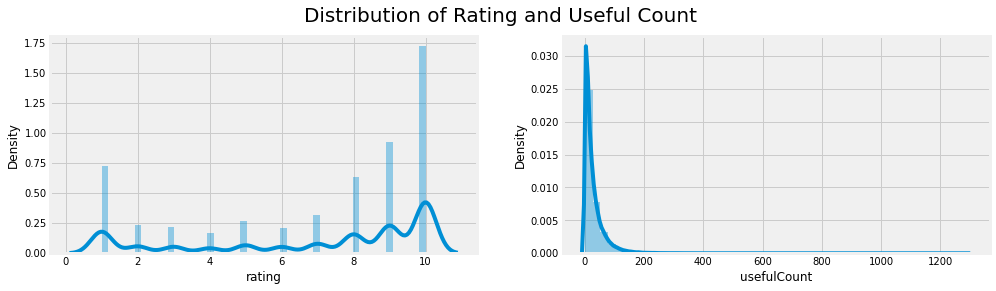

In [10]:
# Checking the Distribution of Rating and Useful Count
 
plt.rcParams['figure.figsize'] = (15, 4)
 
plt.subplot(1, 2, 1)
sns.distplot(data['rating'])
 
plt.subplot(1, 2, 2)
sns.distplot(data['usefulCount'])
 
plt.suptitle('Distribution of Rating and Useful Count \n ', fontsize = 20)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


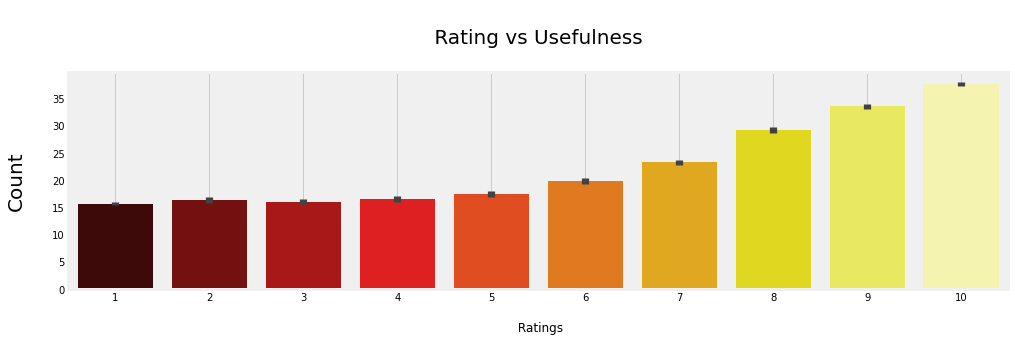

In [11]:
# Checking the Impact of Ratings on Usefulness

plt.rcParams['figure.figsize'] = (15, 4)
sns.barplot(data['rating'], data['usefulCount'], palette = 'hot')
plt.grid()
plt.xlabel('\n Ratings')
plt.ylabel('Count\n', fontsize = 20)
plt.title('\n Rating vs Usefulness \n', fontsize = 20)
plt.show()

In [12]:
# Checking whether Length of Review has any Impact on Ratings of the Drugs

# for that we need to create a new column to calculate length of the reviews
data['len']  = data['review'].apply(len)

In [13]:
# Checking the Impact of Length of Reviews on Ratings
data[['rating','len']].groupby(['rating']).agg(['min','mean','max'])

len                   
       min        mean    max
rating                       
1        5  428.784505   3692
2        9  452.902893  10787
3        8  461.249961   5112
4        7  464.077912   3030
5        6  477.982661   2048
6        4  467.957150   2202
7        6  485.597765   3063
8        3  483.584163   4087
9        3  477.696117   6182
10       3  443.215923   6192

In [14]:
# Checking the Highest Length Review
print("Length of Longest Review", data['len'].max())
data['review'][data['len'] == data['len'].max()].iloc[0]

Length of Longest Review 10787


'"Two and a half months ago I was prescribed Venlafaxine to help prevent chronic migraines.\r\nIt did help the migraines (reduced them by almost half), but with it came a host of side effects that were far worse than the problem I was trying to get rid of.\r\nHaving now come off of the stuff, I would not recommend anyone ever use Venlafaxine unless they suffer from extreme / suicidal depression. I mean extreme in the most emphatic sense of the word. \r\nBefore trying Venlafaxine, I was a writer. While on Venlafaxine, I could barely write or speak or communicate at all. More than that, I just didn&#039;t want to. Not normal for a usually outgoing extrovert.\r\nNow, I&#039;m beginning to write again - but my ability to speak and converse with others has deteriorated by about 95%. Writing these words is taking forever; keeping up in conversation with even one person is impossible, and I barely see the point of trying either. On Venlafaxine, words pretty much left me - my conversational vo

### Cleaning the Reviews

In [15]:
# First lets remove Punctuations from the Reviews
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

data['review'] = data['review'].apply(punctuation_removal)

In [16]:
# Now lets Remove the Stopwords also

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop = stopwords.words('english')
stop.append("i'm")

stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 

def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words ]

data['review'] = data['review'].apply(stopwords_removal)

In [17]:
# Removing the Numbers also

import re
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

data['review'] = data['review'].apply(drop_numbers)

### Calculating the Sentiment from Reviews

In [18]:
# for using Sentiment Analyzer we will have to dowload the Vader Lexicon from NLTK

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [19]:
# Calculating the Sentiment from Reviews

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

train_sentiments = []

for i in data['review']:
    train_sentiments.append(sid.polarity_scores(i).get('compound'))
    
train_sentiments = np.asarray(train_sentiments)
data['sentiment'] = pd.Series(data=train_sentiments)

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [20]:
# Checking Impact of Sentiment on Reviews
data[['rating','sentiment']].groupby(['rating']).agg(['min','mean','max'])

sentiment                  
             min      mean     max
rating                            
1        -0.9931  0.005311  0.9898
2        -0.9929  0.003867  0.9924
3        -0.9925  0.003170  0.9877
4        -0.9919  0.000697  0.9867
5        -0.9920  0.014445  0.9882
6        -0.9914  0.008838  0.9936
7        -0.9938 -0.000509  0.9911
8        -0.9936  0.008952  0.9923
9        -0.9964  0.009489  0.9911
10       -0.9982  0.005446  0.9923

In [21]:
# as we can see that Sentiment and length of the review are not related to Reviews, we will drop the sentiment column

# lets remove the unique Id, date, review, len, and sentiment column also
data = data.drop(['date','uniqueID','sentiment','review','len'], axis = 1)

# lets check the name of columns now
data.columns

Index(['drugName', 'condition', 'rating', 'usefulCount'], dtype='object')

### Calculating Effectiveness and Usefulness of Drugs

In [22]:
# Calculating an Effective Rating


min_rating = data['rating'].min()
max_rating = data['rating'].max()

def scale_rating(rating):
    rating -= min_rating
    rating = rating/(max_rating -1)
    rating *= 5
    rating = int(round(rating,0))
    
    if(int(rating) == 0 or int(rating)==1 or int(rating)==2):
        return 0
    else:
        return 1
    
data['eff_score'] = data['rating'].apply(scale_rating)

In [23]:
# Calculating Usefulness Score

data['usefulness'] = data['rating']*data['usefulCount']*data['eff_score']

# lets check the Top 10 Most Useful Drugs with their Respective Conditions
data[['drugName','condition','usefulness']][data['usefulness'] > 
                            data['usefulness'].mean()].sort_values(by = 'usefulness', 
                                        ascending = False).head(10).reset_index(drop = True)

,drugName,condition,usefulness
0,Sertraline,Depression,12910
1,Zoloft,Depression,12910
2,Levonorgestrel,Birth Control,12470
3,Mirena,Birth Control,12470
4,Zoloft,Depression,8541
5,Phentermine,Weight Loss,7960
6,Adipex-P,Weight Loss,7960
7,Implanon,Birth Control,7300
8,Viibryd,Depression,6930
9,Vilazodone,Depression,6930


### Finding Most Useful and Useless Drugs for each Condition

In [24]:
# lets remove all the Duplicates from the Dataset
data = data.drop_duplicates()

In [25]:
# lets find the Highest and Lowest Rated Drugs for each Condition

@interact
def high_low_rate(condition = list(data['condition'].value_counts().index)):
    print("\n Top 5 Drugs")
    print(data[data['condition'] == condition][['drugName','usefulness']].sort_values(by = 'usefulness',
                                                 ascending = False).head().reset_index(drop = True))
    print("\n\n Bottom 5 Drugs")
    print(data[data['condition'] == condition][['drugName','usefulness']].sort_values(by = 'usefulness',
                                                 ascending = True).head().reset_index(drop = True))

interactive(children=(Dropdown(description='condition', options=('Birth Control', 'Depression', 'Pain', 'Anxie…

In [26]:
# -----------------------------------------------------THE END -------------------------------------------------------#